In [1]:
RANDOM_STATE = 101
no_dummies = False # 'no dummies' in DATA_DETAIL
VERSION = '09'

In [2]:
import sys
import os
import json

module_path = os.path.abspath(os.path.join('..', '..', '..'))
if module_path not in sys.path:
    #sys.path.append(module_path+"\\zfunctions")
    sys.path.append(module_path)

#with open('../../z_envs/_envs.json') as f:
#    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False



if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

#print(env_vars)

ModuleNotFoundError: No module named 'functions_b__get_the_data_20221116'

In [3]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

NameError: name 'get_columns' is not defined

In [11]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))


    df = df[columns]

loaded data from ../../../data/final/df_listings_v09.csv


In [12]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

#print(X_train[0])
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(46871, 19)
(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Epoch 1/10
2483/2483 - 7s - loss: 0.0268 - val_loss: 0.0052 - 7s/epoch - 3ms/step
Epoch 2/10
2483/2483 - 5s - loss: 0.0073 - val_loss: 0.0022 - 5s/epoch - 2ms/step
Epoch 3/10
2483/2483 - 6s - loss: 0.0051 - val_loss: 0.0016 - 6s/epoch - 2ms/step
Epoch 4/10
2483/2483 - 8s - loss: 0.0043 - val_loss: 0.0012 - 8s/epoch - 3ms/step
Epoch 5/10
2483/2483 - 7s - loss: 0.0038 - val_loss: 9.7169e-04 - 7s/epoch - 3ms/step
Epoch 6/10
2483/2483 - 5s - loss: 0.0034 - val_loss: 0.0011 - 5s/epoch - 2ms/step
Epoch 7/10
2483/2483 - 6s - loss: 0.0032 - val_loss: 0.0010 - 6s/epoch - 2ms/step
Epoch 8/10
2483/2483 - 6s - loss: 0.0030 - val_loss: 8.1420e-04 - 6s/epoch - 2ms/step
Epoch 9/10
2483/2483 - 5s - loss: 0.0030 - val_loss: 7.3426e-04 - 5s/epoch - 2ms/step
Epoch 10/10
2483/2483 - 5s - loss: 0.0028 - val_loss: 9.9288e-04 - 5s/epoch - 2ms/step


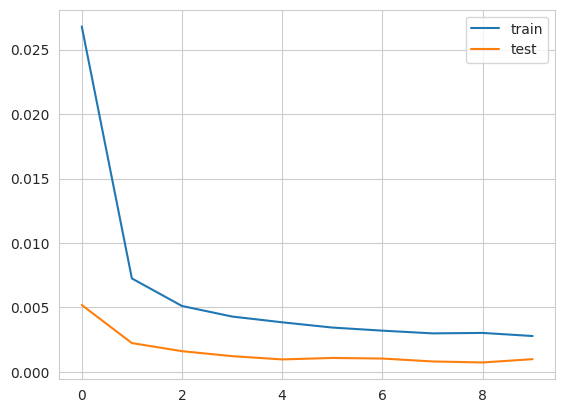

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import BatchNormalization
from keras.utils import plot_model
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# number of input columns
n_inputs = X_train.shape[1]
# split into train test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
#history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
history = model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder_20221220.h5')

In [15]:

y_train = y_train.ravel()
y_test = y_test.ravel()

# support vector regression performance with encoded input
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from keras.models import load_model
# define dataset
#???X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# split into train test sets
#???X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("Before:")
print(y_train[0:5])
print(y_test[0:5])
# reshape target variables so that we can transform them
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))
# scale input data
trans_in = MinMaxScaler()
trans_in.fit(X_train)
X_train = trans_in.transform(X_train)
X_test = trans_in.transform(X_test)
# scale output data
trans_out = MinMaxScaler()
trans_out.fit(y_train)
y_train = trans_out.transform(y_train)
y_test = trans_out.transform(y_test)
print("Scaled:")
print(y_train[0:5])
print(y_test[0:5])
# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define model
model = SVR()
# fit model on the training dataset
model.fit(X_train_encode, y_train)
# make prediction on test set
yhat = model.predict(X_test_encode)
# invert transforms so we can calculate errors
yhat = yhat.reshape((len(yhat), 1))
yhat = trans_out.inverse_transform(yhat)
y_test = trans_out.inverse_transform(y_test)
# calculate error
score = mean_absolute_error(y_test, yhat)
print(score)

Before:
[525000. 225000. 475000. 475000. 425000.]
[400000. 369950. 350000. 549000. 495000.]
Scaled:
[[0.85]
 [0.25]
 [0.75]
 [0.75]
 [0.65]]
[[0.6   ]
 [0.5399]
 [0.5   ]
 [0.898 ]
 [0.79  ]]
138/138 [==============================] - 0s 1ms/step


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


55610.77798026234


In [16]:
from sklearn.svm import SVR
from keras.saving.save import load_model

# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

# define model
model = SVR()
# fit model on the training dataset
model.fit(X_train_encode, y_train)
# make prediction on test set
yhat = model.predict(X_test_encode)

yhat = model.predict(X_test_encode)
# invert transforms so we can calculate errors
yhat = yhat.reshape((len(yhat), 1))
yhat = trans_out.inverse_transform(yhat)
#??? y_test = trans_out.inverse_transform(y_test)
# calculate error
score = mean_absolute_error(y_test, yhat)
print(score)

138/138 [==============================] - 0s 3ms/step


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


212534162728.65912


In [17]:
print(y_test[0], yhat[0])


[2.000001e+11] [417065.05048983]
